In [1]:
import os
import sys
import torch

need_pytorch3d = False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d = True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
        version_str = "".join(
            [
                f"py3{sys.version_info.minor}_cu",
                torch.version.cuda.replace(".", ""),
                f"_pyt{pyt_version_str}",
            ]
        )
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install git+https://github.com/facebookresearch/pytorch3d.git@stable

In [2]:
!pip install trimesh
import locale

locale.getpreferredencoding = lambda: "UTF-8"
!pip install pyrender

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pytorch3d
import numpy as np
import trimesh

In [4]:
mesh = trimesh.load_mesh("D:\project/3DML\data\Dragon\Dragon.obj")
mesh.show()

In [4]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
)
import torch
from pytorch3d.io import load_obj
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.mesh.textures import TexturesAtlas
from torchvision import transforms

model_base_path = "Models"
model_name = "!EXPORT_Isaac_3DML.obj"
model_path = os.path.join(model_base_path, model_name)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Get vertices, faces, and auxiliary information
verts, faces, aux = load_obj(
    f="../data\Dragon\Dragon.obj",
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap=None,
)

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
obj_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),
)

# color = torch.zeros(1, verts.size(1), 3, device=device)
# obj_mesh.textures = TexturesVertex(verts_features=color)

print(
    "We have {0} vertices and {1} faces.".format(
        verts.shape[0], faces.verts_idx.shape[0]
    )
)

# Initialize the camera with camera distance, elevation, and azimuth angle
camera_distance = 12
camera_elv_angle = 30
camera_azi_angle = 0

R, T = look_at_view_transform(
    dist=camera_distance, elev=camera_elv_angle, azim=camera_azi_angle
)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256
output_im_size = 512
raster_settings = RasterizationSettings(
    image_size=output_im_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)

We have 10196 vertices and 20388 faces.


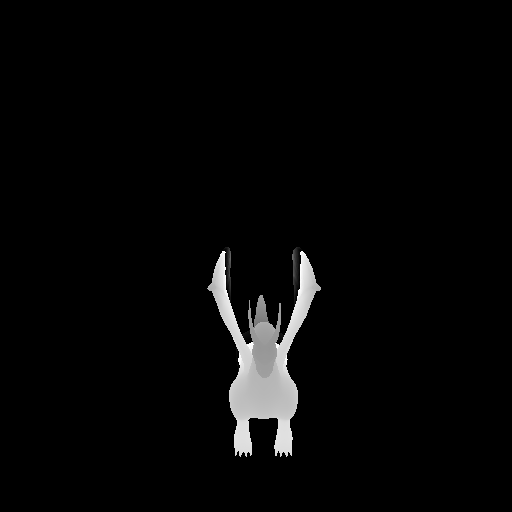

In [5]:
# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# The textured Phong shader interpolates the texture UV coordinates for
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device=device, cameras=cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

# output camera view image
# image = renderer(obj_mesh)
# camera_view = (image[..., :3].squeeze() * 255).byte().cpu().numpy()
# transforms.ToPILImage()(camera_view)

# output depth image
fragments = rasterizer(obj_mesh)
depth_map = ((fragments.zbuf.squeeze() + 1) * 50).byte().cpu().numpy()
transforms.ToPILImage()(depth_map)